In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.tensorboard import SummaryWriter
from model import Discriminator, Generator, initialize_weights

# Hyperparameters etc.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#LEARNING_RATE_GEN = 1e-4  # could also use two lrs, one for gen and one for disc
#LEARNING_RATE_DISC = 4e-4
LEARNING_RATE = 2e-4
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 3
NOISE_DIM = 100
NUM_EPOCHS = 10
FEATURES_DISC = 64
FEATURES_GEN = 64
WORKERS = 6

In [2]:
transforms = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)

# If you train on MNIST, remember to set channels_img to 1

dataset = datasets.ImageFolder('./dataset', transform=transforms)

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=WORKERS)

gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0

In [3]:
try:
    gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN)
    disc = Discriminator(CHANNELS_IMG, FEATURES_DISC)
    
    saved_gen = torch.load("./models/Generator-animev2.tar")
    saved_disc = torch.load("./models/Discriminator-animev2.tar")
    gen.load_state_dict(saved_gen["model_state_dict"])
    disc.load_state_dict(saved_disc["model_state_dict"])
    opt_gen.load_state_dict(saved_gen['optimizer_state_dict'])
    opt_disc.load_state_dict(saved_disc['optimizer_state_dict'])
    gen.train()
    disc.train()
    print("succesfully loaded parameters")
except Exception as e:
    print(e)
    pass

succesfully loaded parameters


In [4]:
for epoch in range(NUM_EPOCHS):
    # Target labels not needed
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(device)
        noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
        fake = gen(noise)

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally and print to tensorboard
        if batch_idx % 45 == 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} \
                  Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(
                    real[:32], normalize=True
                )
                img_grid_fake = torchvision.utils.make_grid(
                    fake[:32], normalize=True
                )

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)
            step += 1

torch.save({
    'epoch': epoch,
    'model_state_dict': gen.state_dict(),
    'optimizer_state_dict': opt_gen.state_dict(),
    'loss': loss_gen,
}, "./models/Generator-animev2.tar")

torch.save({
    'epoch': epoch,
    'model_state_dict': disc.state_dict(),
    'optimizer_state_dict': opt_disc.state_dict(),
    'loss': loss_disc,
}, "./models/Discriminator-animev2.tar")

Epoch [0/10] Batch 0/256                   Loss D: 0.6393, loss G: 1.0362
Epoch [0/10] Batch 45/256                   Loss D: 0.6195, loss G: 1.0428
Epoch [0/10] Batch 90/256                   Loss D: 0.6063, loss G: 1.0441


KeyboardInterrupt: 

In [ ]:
'''torch.save({
    'epoch': epoch,
    'model_state_dict': gen.state_dict(),
    'optimizer_state_dict': opt_gen.state_dict(),
    'loss': loss_gen,
}, "./models/Generator-animev2.tar")'''

torch.save({
    'epoch': epoch,
    'model_state_dict': disc.state_dict(),
    'optimizer_state_dict': opt_disc.state_dict(),
    'loss': loss_disc,
}, "./models/Discriminator-animev2.tar")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [5]:
fixed_noise = torch.randn(1, 100, 1, 1).to(device)
fake = gen(fixed_noise)

fake_img = torchvision.utils.make_grid(
                    fake[:1], normalize=True
                )

show(fake_img)

NameError: name 'show' is not defined

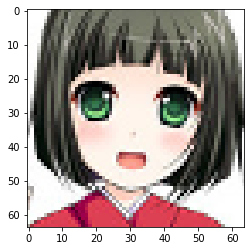

In [ ]:
import random
real_img = torchvision.utils.make_grid(
                    real[:1], normalize=True
                )
show(real_img)